In [2]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.interpolate import barycentric_interpolate
from numpy import linalg as la
from scipy.optimize import root
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

# Setup

In [3]:
def cheb(N):
    x = np.cos((np.pi/N)*np.linspace(0,N,N+1))
    x.shape = (N+1,1)
    lin = np.linspace(0,N,N+1)
    lin.shape = (N+1,1)
    
    c = np.ones((N+1,1))
    c[0], c[-1] = 2., 2.
    c = c*(-1.)**lin
    X = x*np.ones(N+1) # broadcast along 2nd dimension (columns)
    
    dX = X - X.T
    
    D = (c*(1./c).T)/(dX + np.eye(N+1))
    D = D - np.diag(np.sum(D.T,axis=0))
    x.shape = (N+1,)
    # Here we return the differentiation matrix and the Chebyshev points,
    # numbered from x_0 = 1 to x_N = -1
    return D, x

# Problem 1

Use the differentiation matrix to numerically approximate the derivative of $u(x) = e^{x}\cos(6x)$ on a grid of $N$ Chebychev points where N=6, 8, and 10.
Then use barycentric interpolation scipy.interpolate.barycentric_interpolate to approximate u' on a grid of 100 evenly spaced points.

Graphically compare your approximation to the exact derivative.
Note that this convergence would not be occurring if the collocation points were equally spaced.

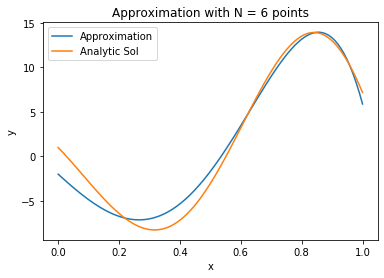

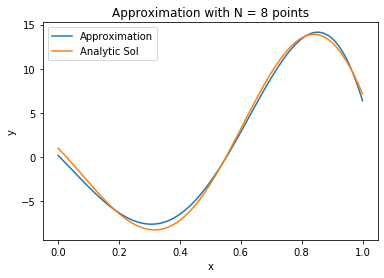

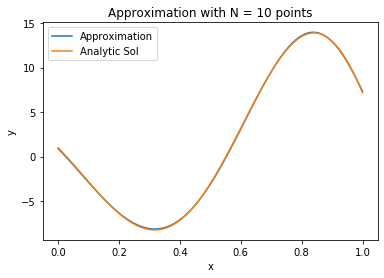

In [96]:
# Define u and its derivative
u = lambda x : np.exp(x) * np.cos(6*x)
u_prime = lambda x : -6*np.sin(6*x) * np.exp(x) + np.cos(6*x) * np.exp(x)

for N in [6, 8, 10]:
    # Get derivative matrix and chebychev points
    D, x = cheb(N)
    
    # Approximate derivative of u, then interpolate more points
    u_approx = D @ u(x)
    lin = np.linspace(0, 1, 100)
    u_bary = barycentric_interpolate(x, u_approx, lin)
    
    # Use analytic sol to compare
    u_sol = u_prime(lin)
    
    # Plot approx and actual sol
    plt.plot(lin, u_bary, label="Approximation")
    plt.plot(lin, u_sol, label="Analytic Sol")
    plt.legend()
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title("Approximation with N = " + str(N) + " points")
    plt.show()

# Problem 2

Use the pseudospectral method to solve the boundary value problem
\begin{align*}
&{ } u'' = e^{2x}, \quad x \in (-1,1), \\
&{ } u(-1) = 0, \quad u(1) = 0.
\end{align*}

Use $N=8$ in the \li{cheb(N)} method and use barycentric interpolation to approximate $u$ on 100 evenly spaced points.
Compare your numerical solution with the exact solution.

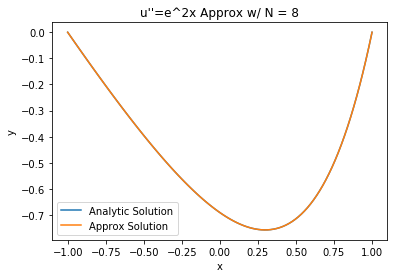

In [70]:
N = 8
# Set up second derivative matrix
D, x = cheb(N)
D2 = np.dot(D, D)
D2[0,:], D2[-1,:] = 0, 0
D2[0,0], D2[-1,-1] = 1, 1
F = np.exp(2*x)
# Adjust F to force U[0] = U[N] = 0
F[0], F[-1] = 0, 0

# Solve for U in D2 @ U = F, then interpolate more points
domain = np.linspace(-1, 1, 100)
u_approx = np.linalg.solve(D2, F)
u_approx = barycentric_interpolate(x, u_approx, domain)

# actual solution u
u = lambda x : (-np.cosh(2)-np.sinh(2)*x+np.exp(2*x)) / 4

# Plot approx and sol
plt.plot(domain, u(domain), label="Analytic Solution")
plt.plot(domain, u_approx, label="Approx Solution")
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.title("u''=e^2x Approx w/ N = 8")
plt.show()

# Problem 3

Use the pseudospectral method to solve the boundary value problem
\begin{align*}
&{ } u'' + u' = e^{3x}, \quad x \in (-1,1), \\
&{ } u(-1) = 2, \quad u(1) = -1.
\end{align*}

Use $N=8$ in the \li{cheb(N)} method and use barycentric interpolation to approximate $u$ on 100 evenly spaced points.

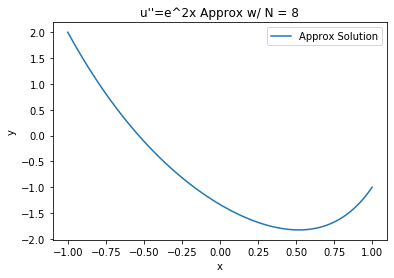

In [94]:
N = 8
D, x = cheb(N)
D2 = np.dot(D, D) + D
D2[0,:], D2[-1,:] = 0, 0
D2[0,0], D2[-1,-1] = 1, 1

F2 = np.exp(3*x)
# Boundary conditions
F2[0], F2[-1] = -1, 2

# Solve for U in D2 @ U = F2, interpolate more points
u_approx = np.linalg.solve(D2, F2)
u_approx = barycentric_interpolate(x, u_approx, domain)

# Plot approx solution
plt.plot(domain, u_approx, label="Approx Solution")
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.title("u''=e^2x Approx w/ N = 8")
plt.show()

# Problem 4

Use the pseudospectral method to solve the boundary value problem
\begin{align*}
&{ } u'' = \lambda\sinh(\lambda u), \quad x \in (0,1), \\
&{ } u(0) = 0, \quad u(1) = 1
\end{align*}
for several values of $\lambda$: $\lambda = 4, 8, 12$. 
Begin by transforming this BVP onto the domain $-1<x<1$.
Use $N=20$ in the cheb(N) method and use barycentric interpolation to approximate $u$ on 100 evenly spaced points.

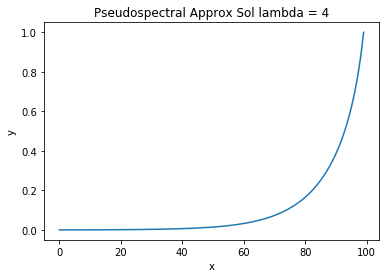

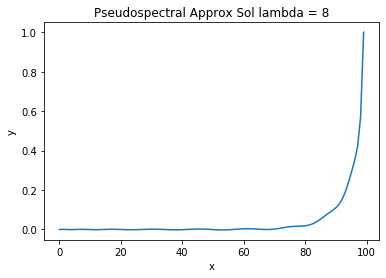

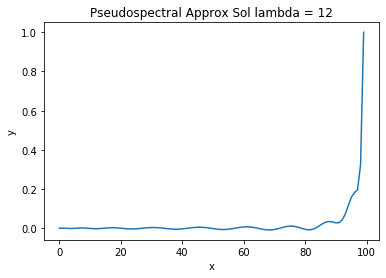

In [81]:
N = 20
# Adjust d/dx matrix to force U[0] = 0 U[N] = 1
D, x = cheb(N)
D2 = np.dot(D, D)
D2[0,:], D2[-1,:] = 1, 0
D2[0,0], D2[-1,-1] = 1, 1

for lamda in [4, 8, 12]:
    # Function to find root (zeros) of using scipy root function
    def func(U):
        F3 = lamda * np.sinh(lamda * U)
        out = D2 @ U - F3
        out[0] = U[0] - 1
        out[-1] = U[-1]
        return out
    
    # Use scipy root function to approx solution, interpolate more points
    guess = np.ones(len(x))
    u_approx = root(func, guess).x
    domain = np.linspace(-1, 1, 100)
    u_approx = barycentric_interpolate(x, u_approx, domain)
    
    # Plot the solution
    plt.plot(u_approx)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title("Pseudospectral Approx Sol lambda = " + str(lamda))
    plt.show()

# Problem 5

Find the function $y(x)$ that satisfies $y(-1) = 1$, $y(1) = 7$, and whose surface of revolution (about the $x$-axis) minimizes surface area.
Compute the surface area, and plot the surface. \label{prob:pseudospectral1_revision:minimal_surface}
Use $N=50$ in the cheb(N) method and use barycentric interpolation to approximate $u$ on 100 evenly spaced points.


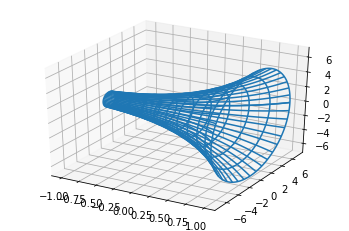

In [95]:
N = 50
D, x = cheb(N)
D2 = np.dot(D, D)
D2[0,:], D2[-1,:] = 0, 0
D2[0,0], D2[-1,-1] = 1, 1

F = np.ones(N+1)

def func(Y):
    out = Y * (D2 @ Y) - (D @ Y) * (D @ Y) - F
    # Boundary conditions since root tries to zero out return value out
    out[0] = Y[0] - 7
    out[-1] = Y[-1] - 1
    return out

# Approx sol using scipy root function, interpolate more points
guess = 2*np.ones(len(x))
u_approx = root(func, guess).x
domain = np.linspace(-1, 1, 100)
barycentric = barycentric_interpolate(x, u_approx, domain)

# Plot the solution using 3d wire plotting
lin = np.linspace(-1, 1, 100)
theta = np.linspace(0,2*np.pi,401)
X, T = np.meshgrid(lin, theta)
Y, Z = barycentric*np.cos(T), barycentric*np.sin(T)
fig = plt.figure()
ax = fig.gca(projection="3d")
ax.plot_wireframe(X, Y, Z, rstride=10, cstride=10)
plt.show()